In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, precision_score, recall_score)
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [5]:
detailed_matches_player_stats = pd.read_csv('detailed_matches_player_stats.csv')
economy_data = pd.read_csv('economy_data.csv')
maps_stats = pd.read_csv('maps_stats.csv')
matches = pd.read_csv('matches.csv')
event_info = pd.read_csv('event_info.csv')
agents_stats = pd.read_csv('agents_stats.csv')
detailed_matches_maps = pd.read_csv('detailed_matches_maps.csv')
detailed_matches_overview = pd.read_csv('detailed_matches_overview.csv')
player_stats = pd.read_csv('player_stats.csv')
performance_data = pd.read_csv('performance_data.csv')

In [6]:
def convert_percent(x):
    if isinstance(x, str):
        return float(x.replace('%', ''))
    return float(x) if not pd.isna(x) else 0

def parse_economy_won(val):
    if pd.isna(val) or val == '':
        return 0
    try:
        return int(str(val).split('(')[1].replace(')', ''))
    except:
        return 0
detailed_matches_player_stats['kast_clean'] = detailed_matches_player_stats['kast'].apply(convert_percent)
detailed_matches_player_stats['hs_percent_clean'] = detailed_matches_player_stats['hs_percent'].apply(convert_percent)
df_base = matches.copy()

In [7]:
df_merged = pd.merge(
    df_base,
    detailed_matches_overview[['match_id', 'patch', 'maps_played']],
    on='match_id',
    how='left'
)
player_stats_agg = detailed_matches_player_stats.groupby(['match_id', 'player_team']).agg({
    'rating': 'mean',
    'acs': 'mean',
    'k': 'sum',
    'd': 'sum',
    'a': 'sum',
    'kd_diff': 'sum',
    'kast_clean': 'mean',
    'adr': 'mean',
    'hs_percent_clean': 'mean',
    'fk': 'sum',
    'fd': 'sum'
}).reset_index()
team1_stats = player_stats_agg.copy()
team1_stats.columns = ['match_id', 'team1', 'team1_avg_rating', 'team1_avg_acs', 
                        'team1_total_kills', 'team1_total_deaths', 'team1_total_assists', 
                        'team1_kd_diff', 'team1_avg_kast', 'team1_avg_adr', 
                        'team1_avg_hs', 'team1_fk', 'team1_fd']
team2_stats = player_stats_agg.copy()
team2_stats.columns = ['match_id', 'team2', 'team2_avg_rating', 'team2_avg_acs', 
                        'team2_total_kills', 'team2_total_deaths', 'team2_total_assists', 
                        'team2_kd_diff', 'team2_avg_kast', 'team2_avg_adr', 
                        'team2_avg_hs', 'team2_fk', 'team2_fd']
df_merged = pd.merge(df_merged, team1_stats, on=['match_id', 'team1'], how='left')
df_merged = pd.merge(df_merged, team2_stats, on=['match_id', 'team2'], how='left')

In [8]:
df_merged.head()

,date,match_id,time,team1,score1,team2,score2,score,winner,status,...,team2_avg_acs,team2_total_kills,team2_total_deaths,team2_total_assists,team2_kd_diff,team2_avg_kast,team2_avg_adr,team2_avg_hs,team2_fk,team2_fd
0,"Fri, September 12, 2025",542195,6:30 PM,Paper Rex,2,Xi Lai Gaming,0,2-0,Paper Rex,Completed,...,183.533333,252,326,100,-74,63.466667,121.266667,33.533333,36,44
1,"Fri, September 12, 2025",542196,8:55 PM,GIANTX,2,Sentinels,1,2-1,GIANTX,Completed,...,183.700000,374,398,186,-24,69.950000,117.450000,27.550000,56,60
2,"Sat, September 13, 2025",542207,6:30 PM,NRG,2,EDward Gaming,0,2-0,NRG,Completed,...,198.200000,392,408,140,-16,72.066667,130.933333,28.000000,62,50
3,"Sat, September 13, 2025",542205,9:25 PM,Team Liquid,0,DRX,2,0-2,DRX,Completed,...,192.066667,306,244,138,62,78.266667,127.466667,34.800000,50,38
4,"Sun, September 14, 2025",542212,6:30 PM,Dragon Ranger Gaming,0,T1,2,0-2,T1,Completed,...,206.466667,414,420,162,-6,71.600000,131.266667,31.400000,56,60


In [9]:
economy_data['eco_won'] = economy_data['Eco (won)'].apply(parse_economy_won)
economy_data['fullbuy_won'] = economy_data['Full buy(won)'].apply(parse_economy_won)

economy_agg = economy_data.groupby('match_id').agg({
    'Pistol Won': 'sum',
    'eco_won': 'sum',
    'fullbuy_won': 'sum'
}).reset_index()
economy_agg.columns = ['match_id', 'total_pistol_won', 'total_eco_won', 'total_fullbuy_won']

df_merged = pd.merge(df_merged, economy_agg, on='match_id', how='left')
performance_agg = performance_data.groupby('Match ID').agg({
    '2K': 'sum',
    '3K': 'sum',
    '4K': 'sum',
    '5K': 'sum',
    '1v1': 'sum',
    '1v2': 'sum',
    'ECON': 'sum'
}).reset_index()
performance_agg.columns = ['match_id', 'total_2k', 'total_3k', 'total_4k', 'total_5k',
                           'total_1v1', 'total_1v2', 'total_econ']

df_merged = pd.merge(df_merged, performance_agg, on='match_id', how='left')

print(f"✓ Merged dataset: {df_merged.shape}")

✓ Merged dataset: (34, 46)


In [10]:
df_merged.to_csv('merged_valorant_data.csv', index=False)
print("✓ Saved: merged_valorant_data.csv")

✓ Saved: merged_valorant_data.csv


In [11]:
df_merged['team1_wins'] = (df_merged['winner'] == df_merged['team1']).astype(int)

In [12]:
feature_columns = [
    'team1_avg_rating', 'team1_avg_acs', 'team1_total_kills', 'team1_total_deaths',
    'team1_total_assists', 'team1_kd_diff', 'team1_avg_kast', 'team1_avg_adr',
    'team1_avg_hs', 'team1_fk', 'team1_fd',
    'team2_avg_rating', 'team2_avg_acs', 'team2_total_kills', 'team2_total_deaths',
    'team2_total_assists', 'team2_kd_diff', 'team2_avg_kast', 'team2_avg_adr',
    'team2_avg_hs', 'team2_fk', 'team2_fd',
    'total_pistol_won', 'total_eco_won', 'total_fullbuy_won',
    'total_2k', 'total_3k', 'total_4k', 'total_5k', 'total_1v1', 'total_1v2'
]
df_ml = df_merged[feature_columns + ['team1_wins', 'team1', 'team2', 'winner']].dropna()

X = df_ml[feature_columns]
y = df_ml['team1_wins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {len(feature_columns)}")

Training samples: 25
Test samples: 7
Features: 31


In [13]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42),
    'Naive Bayes': GaussianNB()
}
results = {}
predictions = {}
for name,model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'model': model
    }
    print(f"{name}: Accuracy={accuracy:.3f}, F1={f1:.3f}")
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1-Score': [results[m]['f1'] for m in results]
})
results_df.to_csv('model_performance.csv', index=False)
print("\n✓ Saved: model_performance.csv")

Random Forest: Accuracy=1.000, F1=1.000
Gradient Boosting: Accuracy=0.857, F1=0.889
Logistic Regression: Accuracy=1.000, F1=1.000
SVM: Accuracy=1.000, F1=1.000
KNN: Accuracy=1.000, F1=1.000
Decision Tree: Accuracy=0.857, F1=0.889
AdaBoost: Accuracy=1.000, F1=1.000
Naive Bayes: Accuracy=0.857, F1=0.889

✓ Saved: model_performance.csv


In [14]:
import os
os.makedirs('visualizations', exist_ok=True)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

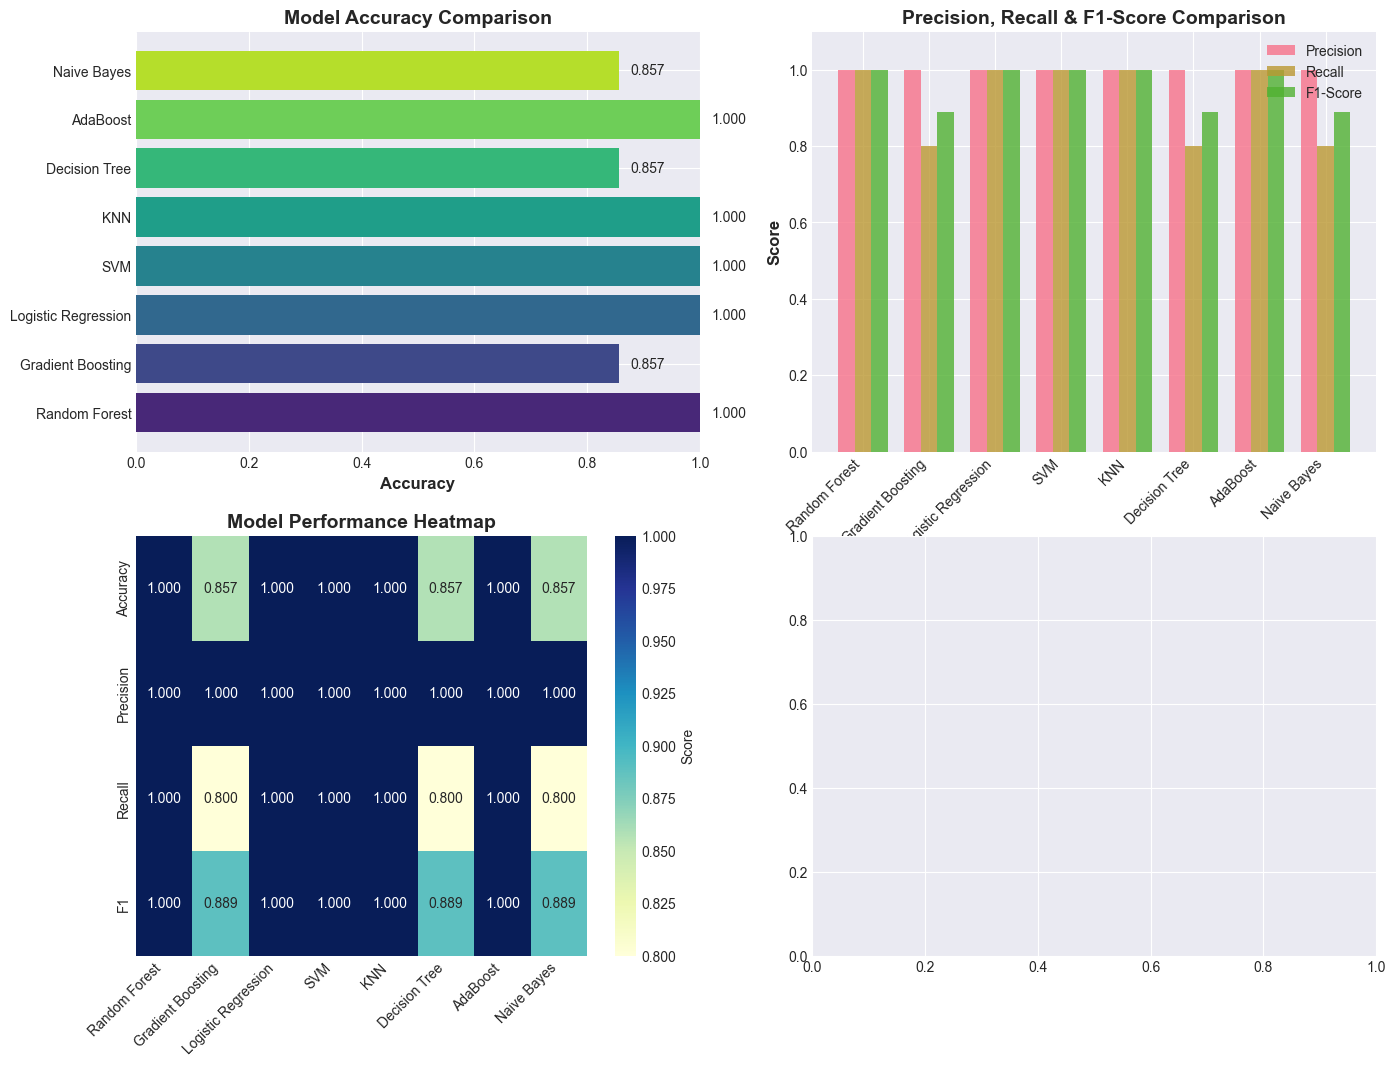

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
ax = axes[0, 0]
models_list = list(results.keys())
accuracies = [results[m]['accuracy'] for m in models_list]
bars = ax.barh(models_list, accuracies, color=sns.color_palette("viridis", len(models_list)))
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1)
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    ax.text(acc + 0.02, i, f'{acc:.3f}', va='center', fontsize=10)

ax = axes[0, 1]
x = np.arange(len(models_list))
width = 0.25
ax.bar(x - width, [results[m]['precision'] for m in models_list], width, label='Precision', alpha=0.8)
ax.bar(x, [results[m]['recall'] for m in models_list], width, label='Recall', alpha=0.8)
ax.bar(x + width, [results[m]['f1'] for m in models_list], width, label='F1-Score', alpha=0.8)
ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Precision, Recall & F1-Score Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models_list, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1.1)

ax = axes[1, 0]
metrics_matrix = np.array([
    [results[m]['accuracy'] for m in models_list],
    [results[m]['precision'] for m in models_list],
    [results[m]['recall'] for m in models_list],
    [results[m]['f1'] for m in models_list]
])
sns.heatmap(metrics_matrix, annot=True, fmt='.3f', cmap='YlGnBu', 
            xticklabels=models_list, yticklabels=['Accuracy', 'Precision', 'Recall', 'F1'],
            cbar_kws={'label': 'Score'}, ax=ax)
ax.set_title('Model Performance Heatmap', fontsize=14, fontweight='bold')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

In [16]:
ax = axes[1, 1]
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model_metrics = [
    results[best_model_name]['accuracy'],
    results[best_model_name]['precision'],
    results[best_model_name]['recall'],
    results[best_model_name]['f1']
]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors_best = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
bars = ax.bar(metric_names, best_model_metrics, color=colors_best, alpha=0.7, edgecolor='black')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title(f'Best Model: {best_model_name}', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.1)
for bar, metric in zip(bars, best_model_metrics):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{metric:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/01_model_comparison.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: 01_model_comparison.png")

✓ Saved: 01_model_comparison.png


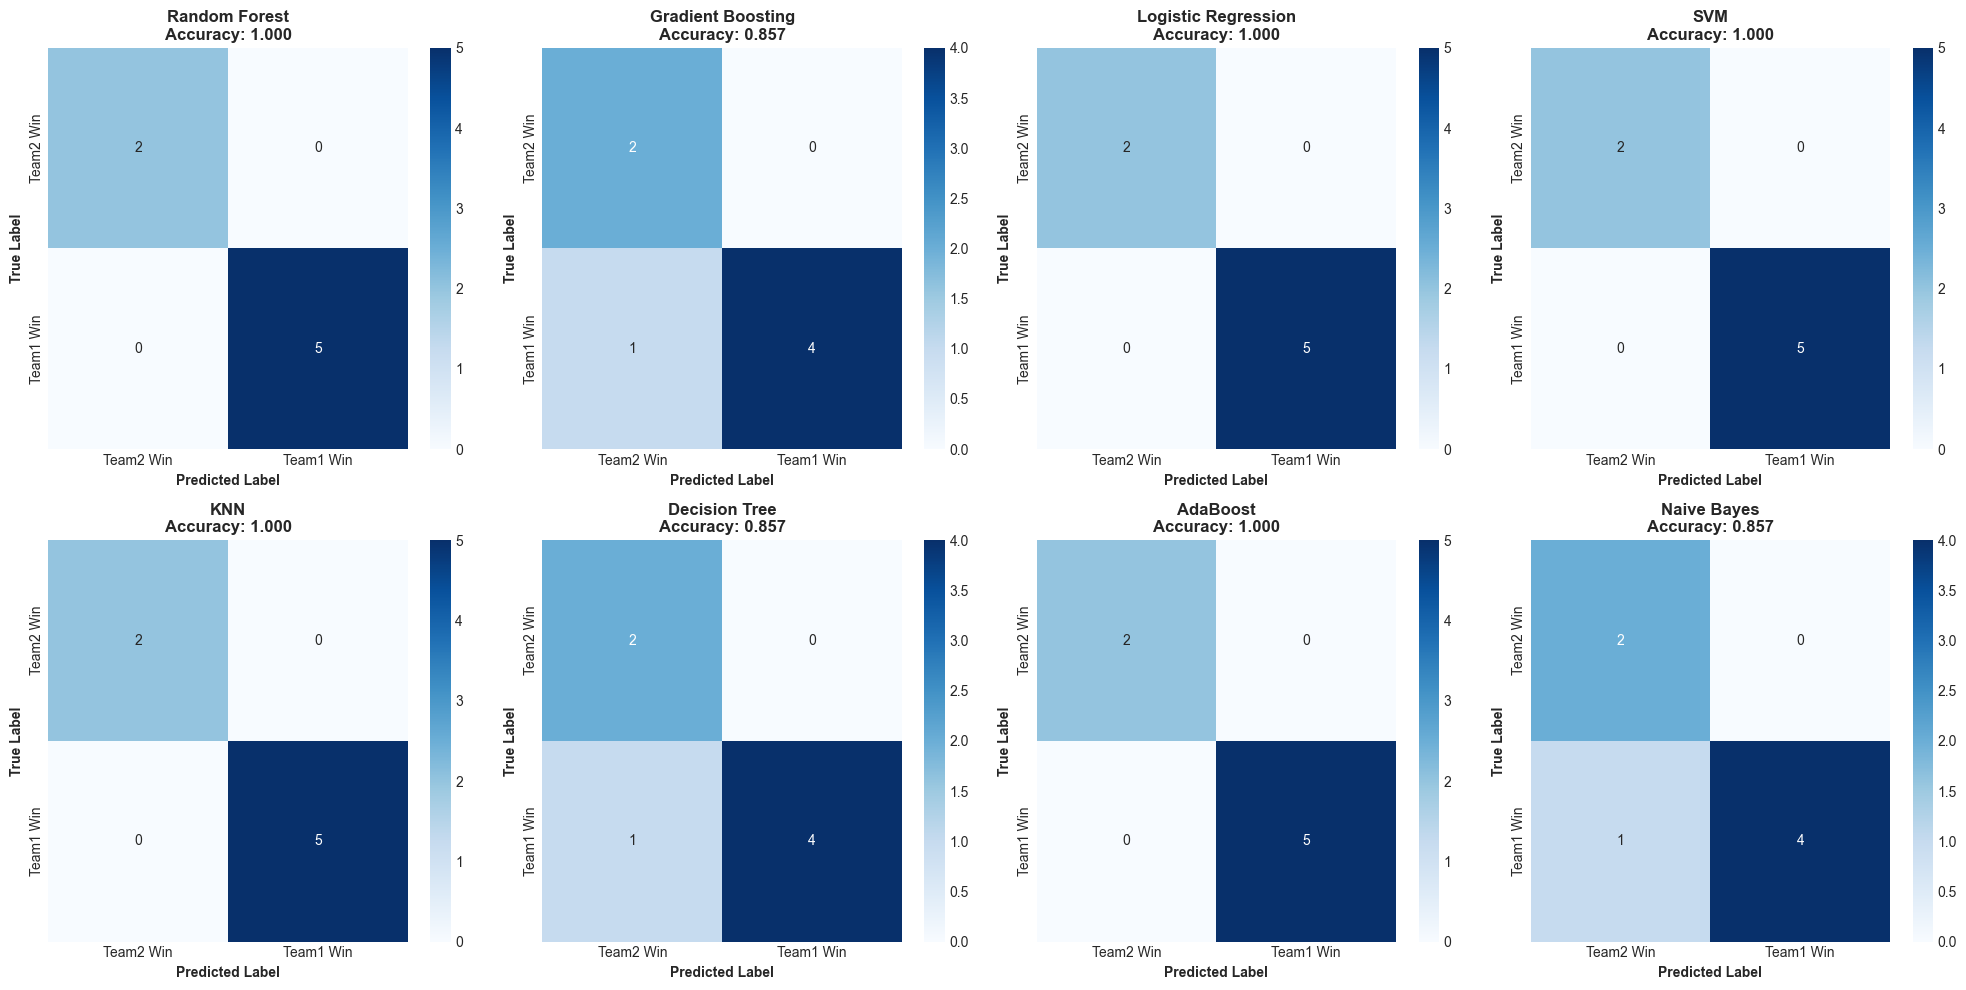

✓ Saved: 02_confusion_matrices.png


In [18]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Team2 Win', 'Team1 Win'],
                yticklabels=['Team2 Win', 'Team1 Win'])
    axes[idx].set_title(f'{name}\nAccuracy: {result["accuracy"]:.3f}', fontweight='bold')
    axes[idx].set_ylabel('True Label', fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/02_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved: 02_confusion_matrices.png")

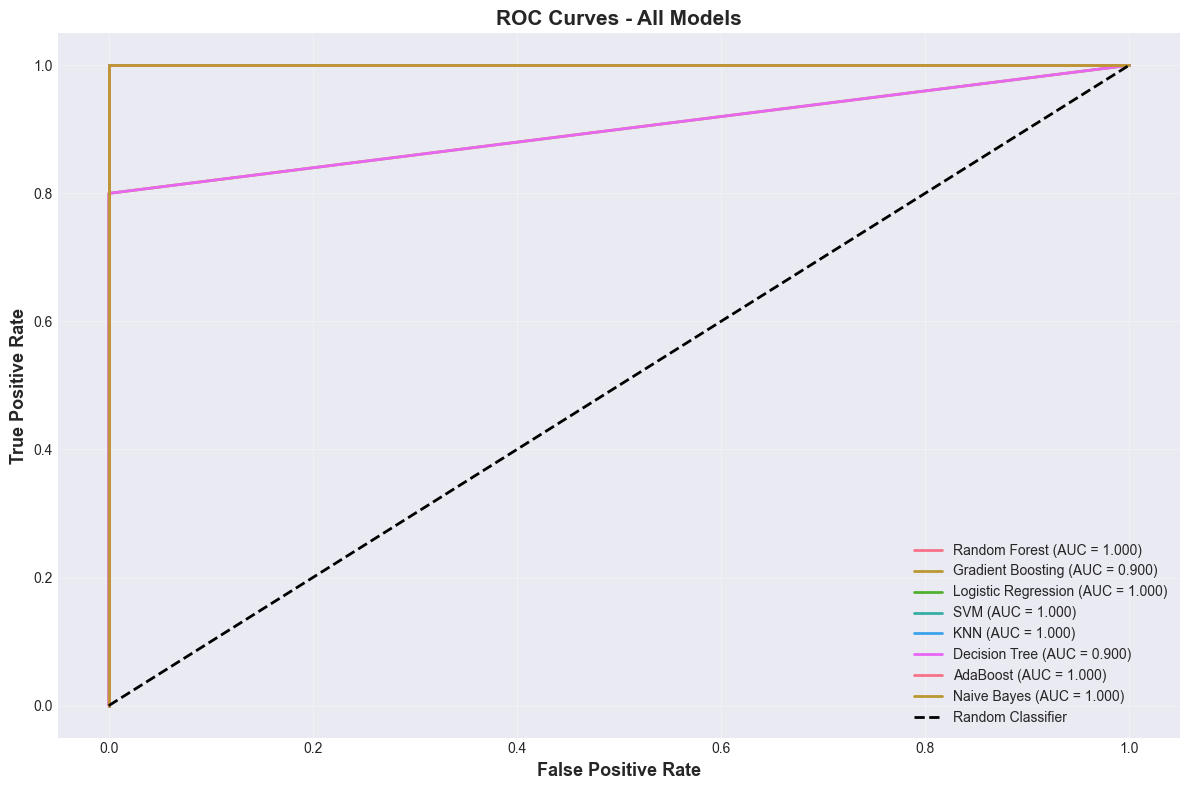

✓ Saved: 03_roc_curves.png


In [19]:
plt.figure(figsize=(12, 8))

for name, result in results.items():
    if result['probabilities'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
        auc = roc_auc_score(y_test, result['probabilities'])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curves - All Models', fontsize=15, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/03_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved: 03_roc_curves.png")

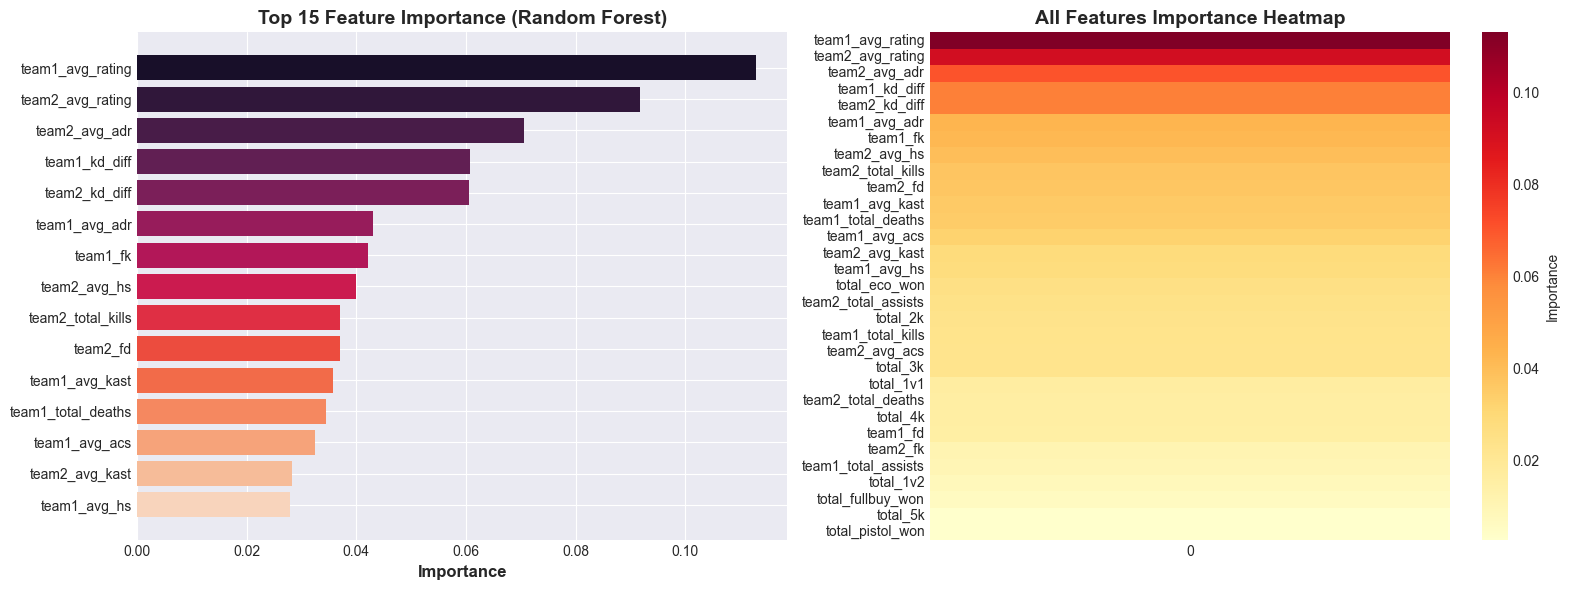

✓ Saved: 04_feature_importance.png


In [ ]:
rf_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
top_features = feature_importance.head(15)
bars = ax.barh(top_features['feature'], top_features['importance'], 
               color=sns.color_palette("rocket", len(top_features)))
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
ax.invert_yaxis()

ax = axes[1]
importance_matrix = feature_importance['importance'].values.reshape(-1, 1)
sns.heatmap(importance_matrix, annot=False, cmap='YlOrRd', 
            yticklabels=feature_importance['feature'], ax=ax, cbar_kws={'label': 'Importance'})
ax.set_title('All Features Importance Heatmap', fontsize=14, fontweight='bold')
ax.set_xlabel('')

plt.tight_layout()
plt.savefig('visualizations/04_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved: 04_feature_importance.png")

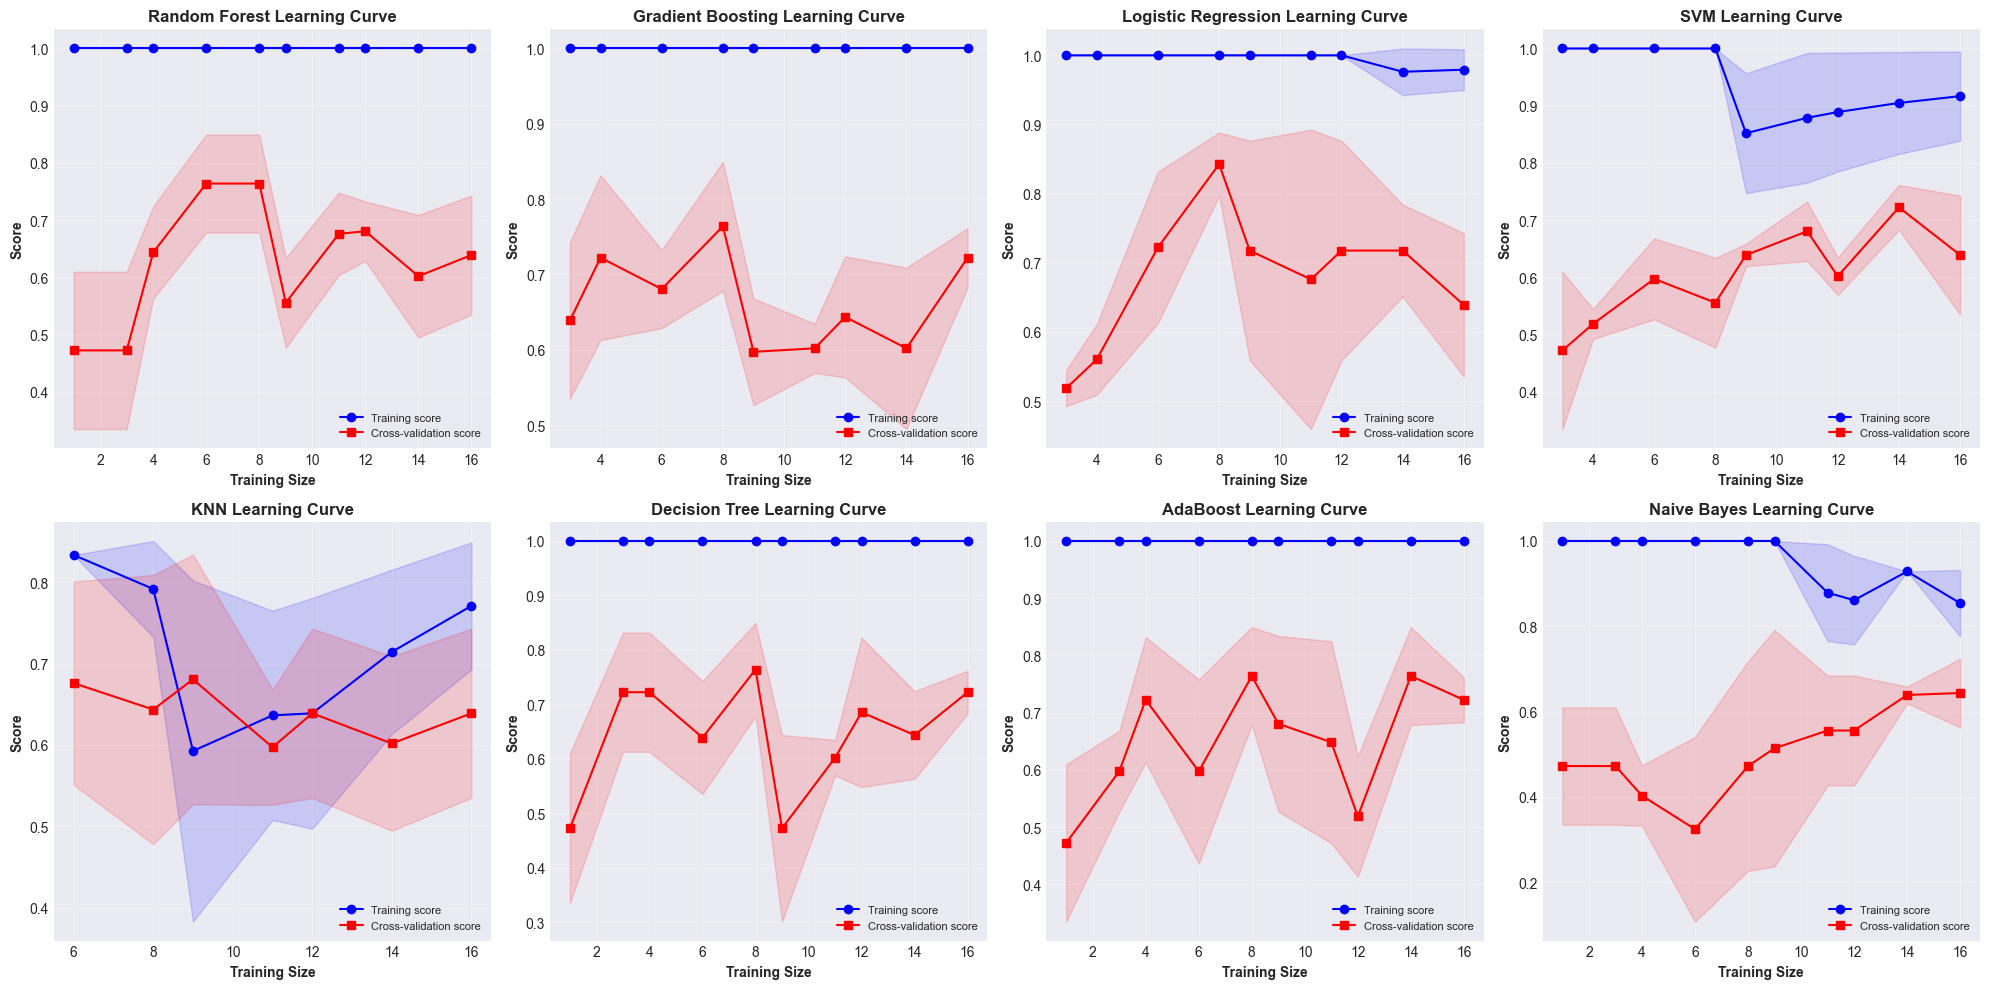

✓ Saved: 05_learning_curves.png


In [21]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    model = result['model']
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train_scaled, y_train, cv=3, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    axes[idx].plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
    axes[idx].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
    axes[idx].plot(train_sizes, val_mean, label='Cross-validation score', color='red', marker='s')
    axes[idx].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='red')
    axes[idx].set_xlabel('Training Size', fontweight='bold')
    axes[idx].set_ylabel('Score', fontweight='bold')
    axes[idx].set_title(f'{name} Learning Curve', fontweight='bold')
    axes[idx].legend(loc='lower right', fontsize=8)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/05_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved: 05_learning_curves.png")

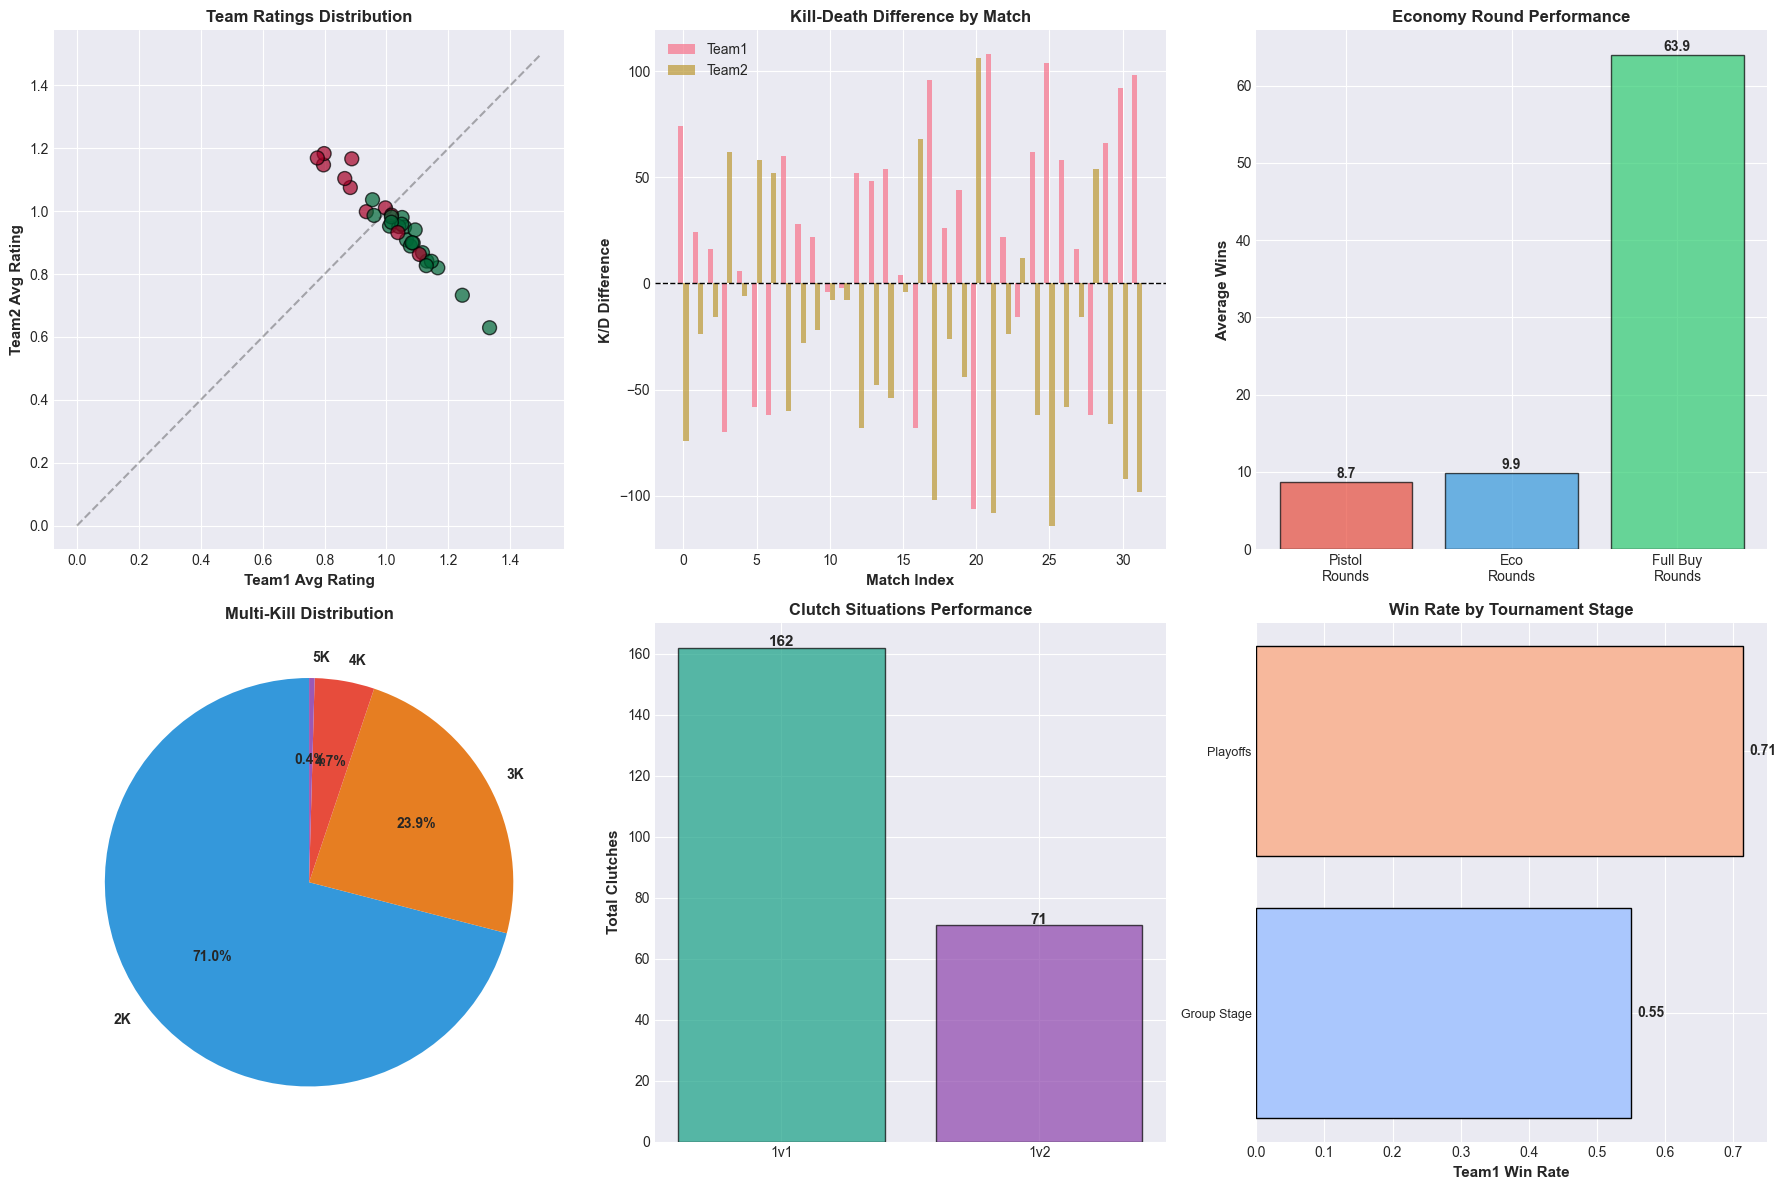

✓ Saved: 06_data_distribution.png


In [22]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

ax = axes[0, 0]
ax.scatter(df_ml['team1_avg_rating'], df_ml['team2_avg_rating'], 
           c=df_ml['team1_wins'], cmap='RdYlGn', s=100, alpha=0.7, edgecolors='black')
ax.set_xlabel('Team1 Avg Rating', fontsize=11, fontweight='bold')
ax.set_ylabel('Team2 Avg Rating', fontsize=11, fontweight='bold')
ax.set_title('Team Ratings Distribution', fontsize=12, fontweight='bold')
ax.plot([0, 1.5], [0, 1.5], 'k--', alpha=0.3)

ax = axes[0, 1]
width = 0.35
x_pos = np.arange(len(df_ml))
ax.bar(x_pos - width/2, df_ml['team1_kd_diff'], width, label='Team1', alpha=0.7)
ax.bar(x_pos + width/2, df_ml['team2_kd_diff'], width, label='Team2', alpha=0.7)
ax.set_xlabel('Match Index', fontsize=11, fontweight='bold')
ax.set_ylabel('K/D Difference', fontsize=11, fontweight='bold')
ax.set_title('Kill-Death Difference by Match', fontsize=12, fontweight='bold')
ax.legend()
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

ax = axes[0, 2]
economy_metrics = ['total_pistol_won', 'total_eco_won', 'total_fullbuy_won']
economy_data_viz = df_ml[economy_metrics].mean()
bars = ax.bar(range(len(economy_data_viz)), economy_data_viz.values, 
              color=['#e74c3c', '#3498db', '#2ecc71'], alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(economy_metrics)))
ax.set_xticklabels(['Pistol\nRounds', 'Eco\nRounds', 'Full Buy\nRounds'], fontsize=10)
ax.set_ylabel('Average Wins', fontsize=11, fontweight='bold')
ax.set_title('Economy Round Performance', fontsize=12, fontweight='bold')
for bar, val in zip(bars, economy_data_viz.values):
    ax.text(bar.get_x() + bar.get_width()/2., val + 0.5,
            f'{val:.1f}', ha='center', fontweight='bold')

ax = axes[1, 0]
multikill_data = df_ml[['total_2k', 'total_3k', 'total_4k', 'total_5k']].sum()
colors_mk = ['#3498db', '#e67e22', '#e74c3c', '#9b59b6']
wedges, texts, autotexts = ax.pie(multikill_data, labels=['2K', '3K', '4K', '5K'],
                                    autopct='%1.1f%%', colors=colors_mk,
                                    startangle=90, textprops={'fontweight': 'bold'})
ax.set_title('Multi-Kill Distribution', fontsize=12, fontweight='bold')

ax = axes[1, 1]
clutch_data = df_ml[['total_1v1', 'total_1v2']].sum()
ax.bar(['1v1', '1v2'], clutch_data.values, color=['#16a085', '#8e44ad'], alpha=0.7, edgecolor='black')
ax.set_ylabel('Total Clutches', fontsize=11, fontweight='bold')
ax.set_title('Clutch Situations Performance', fontsize=12, fontweight='bold')
for i, val in enumerate(clutch_data.values):
    ax.text(i, val + 0.5, f'{int(val)}', ha='center', fontweight='bold', fontsize=11)

ax = axes[1, 2]
if 'stage' in df_merged.columns:
    stage_wins = df_merged.groupby('stage')['team1_wins'].mean()
    bars = ax.barh(range(len(stage_wins)), stage_wins.values, 
                   color=sns.color_palette("coolwarm", len(stage_wins)), edgecolor='black')
    ax.set_yticks(range(len(stage_wins)))
    ax.set_yticklabels(stage_wins.index, fontsize=9)
    ax.set_xlabel('Team1 Win Rate', fontsize=11, fontweight='bold')
    ax.set_title('Win Rate by Tournament Stage', fontsize=12, fontweight='bold')
    for i, (bar, val) in enumerate(zip(bars, stage_wins.values)):
        ax.text(val + 0.01, i, f'{val:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/06_data_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved: 06_data_distribution.png")

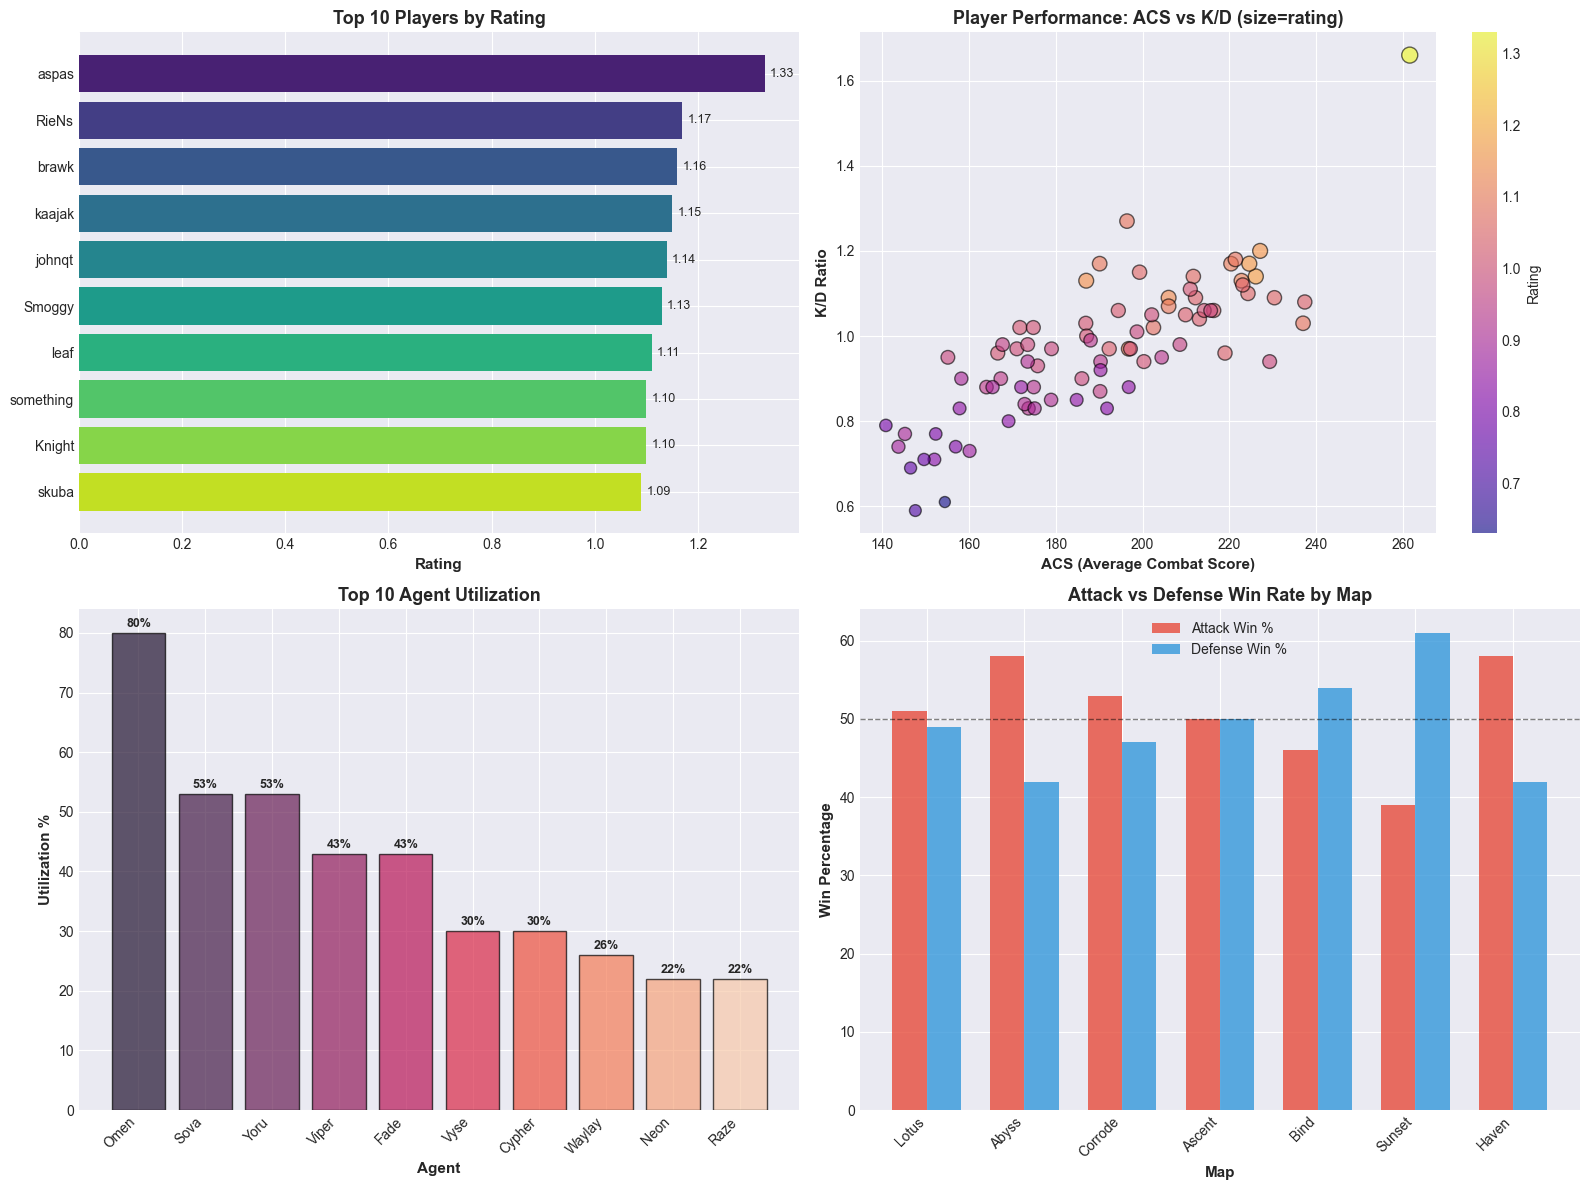

✓ Saved: 07_player_performance.png


In [23]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax = axes[0, 0]
top_players = player_stats.nlargest(10, 'rating')
bars = ax.barh(top_players['player_name'], top_players['rating'], 
               color=sns.color_palette("viridis", len(top_players)))
ax.set_xlabel('Rating', fontsize=11, fontweight='bold')
ax.set_title('Top 10 Players by Rating', fontsize=13, fontweight='bold')
ax.invert_yaxis()
for i, (bar, rating) in enumerate(zip(bars, top_players['rating'])):
    ax.text(rating + 0.01, i, f'{rating:.2f}', va='center', fontsize=9)

ax = axes[0, 1]
scatter = ax.scatter(player_stats['acs'], player_stats['kd_ratio'], 
                     s=player_stats['rating']*100, c=player_stats['rating'],
                     cmap='plasma', alpha=0.6, edgecolors='black')
ax.set_xlabel('ACS (Average Combat Score)', fontsize=11, fontweight='bold')
ax.set_ylabel('K/D Ratio', fontsize=11, fontweight='bold')
ax.set_title('Player Performance: ACS vs K/D (size=rating)', fontsize=13, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Rating')

ax = axes[1, 0]
top_agents = agents_stats.nlargest(10, 'total_utilization')
bars = ax.bar(top_agents['agent_name'], top_agents['total_utilization'],
              color=sns.color_palette("rocket", len(top_agents)), alpha=0.7, edgecolor='black')
ax.set_xlabel('Agent', fontsize=11, fontweight='bold')
ax.set_ylabel('Utilization %', fontsize=11, fontweight='bold')
ax.set_title('Top 10 Agent Utilization', fontsize=13, fontweight='bold')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
for bar, util in zip(bars, top_agents['total_utilization']):
    ax.text(bar.get_x() + bar.get_width()/2., util + 1,
            f'{util:.0f}%', ha='center', fontsize=9, fontweight='bold')

ax = axes[1, 1]
if not maps_stats.empty:
    map_names = maps_stats['map_name']
    attack_wr = maps_stats['attack_win_percent'].apply(lambda x: float(str(x).replace('%', '')))
    defense_wr = maps_stats['defense_win_percent'].apply(lambda x: float(str(x).replace('%', '')))
    
    x = np.arange(len(map_names))
    width = 0.35
    ax.bar(x - width/2, attack_wr, width, label='Attack Win %', alpha=0.8, color='#e74c3c')
    ax.bar(x + width/2, defense_wr, width, label='Defense Win %', alpha=0.8, color='#3498db')
    ax.set_xlabel('Map', fontsize=11, fontweight='bold')
    ax.set_ylabel('Win Percentage', fontsize=11, fontweight='bold')
    ax.set_title('Attack vs Defense Win Rate by Map', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(map_names, rotation=45, ha='right')
    ax.legend()
    ax.axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.savefig('visualizations/07_player_performance.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved: 07_player_performance.png")


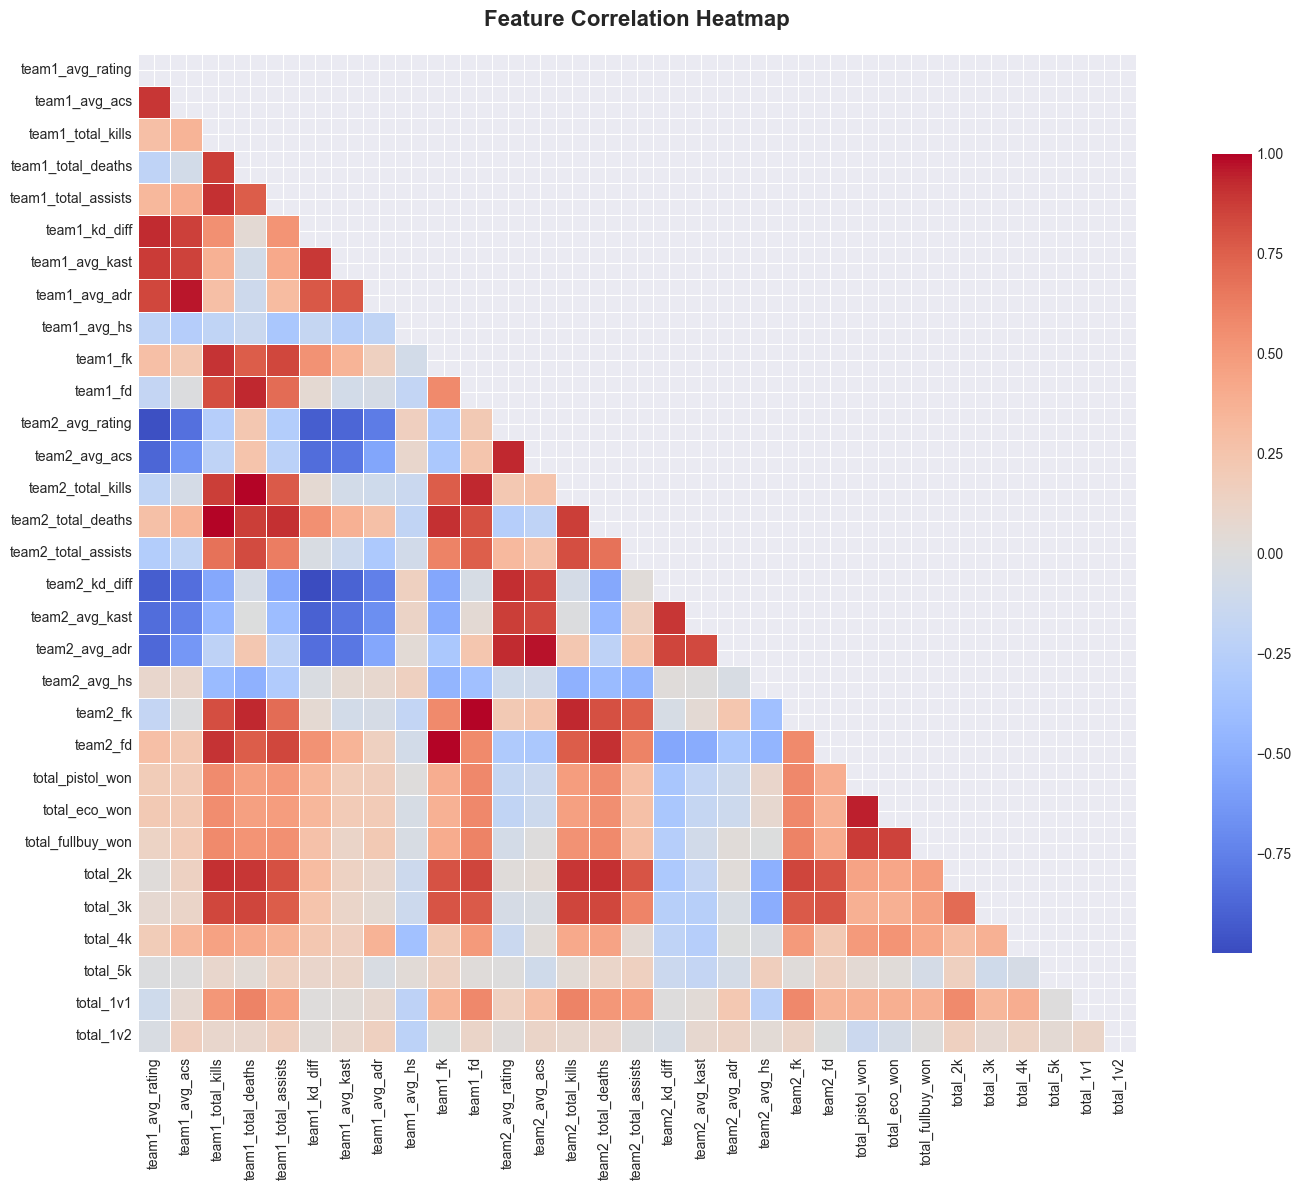

✓ Saved: 08_correlation_heatmap.png


In [24]:
plt.figure(figsize=(16, 12))
correlation_matrix = X.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('visualizations/08_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved: 08_correlation_heatmap.png")

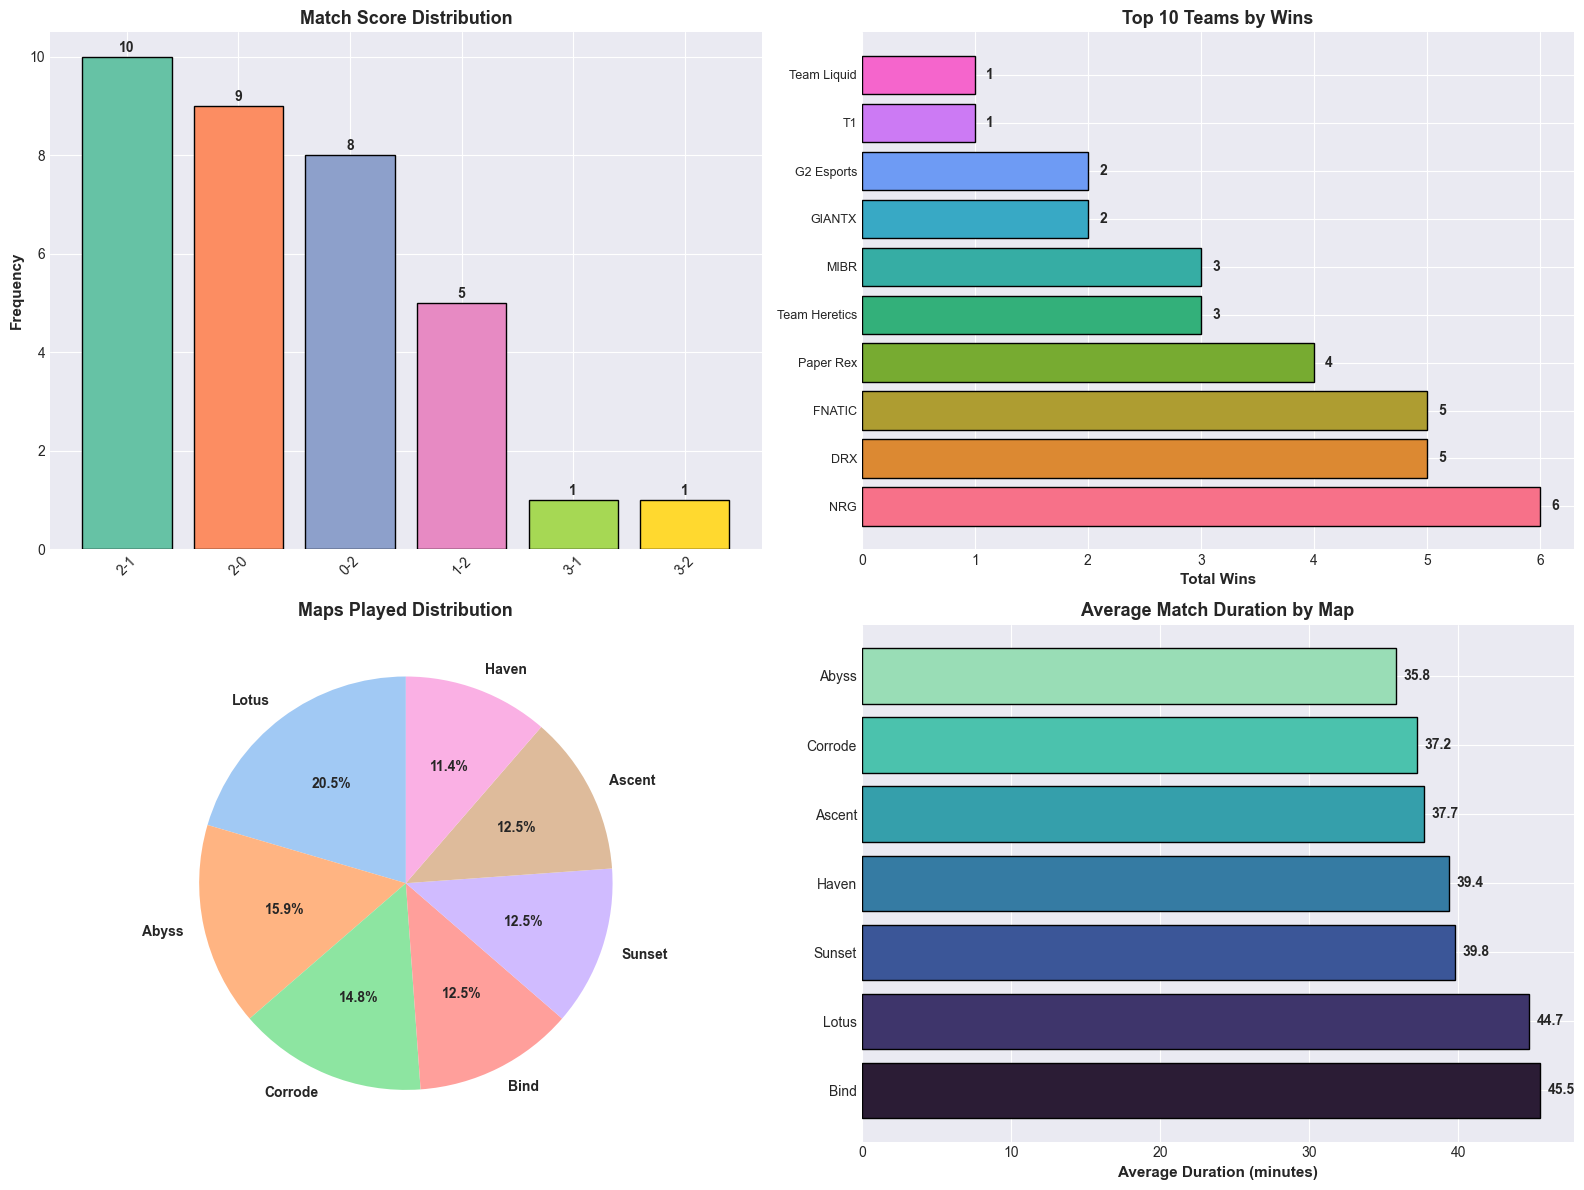

✓ Saved: 09_match_analysis.png


In [25]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax = axes[0, 0]
score_counts = df_merged['score'].value_counts().head(10)
bars = ax.bar(range(len(score_counts)), score_counts.values, 
              color=sns.color_palette("Set2", len(score_counts)), edgecolor='black')
ax.set_xticks(range(len(score_counts)))
ax.set_xticklabels(score_counts.index, rotation=45)
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Match Score Distribution', fontsize=13, fontweight='bold')
for bar, count in zip(bars, score_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2., count + 0.1,
            f'{count}', ha='center', fontweight='bold')

ax = axes[0, 1]
team_wins = df_merged['winner'].value_counts().head(10)
bars = ax.barh(range(len(team_wins)), team_wins.values,
               color=sns.color_palette("husl", len(team_wins)), edgecolor='black')
ax.set_yticks(range(len(team_wins)))
ax.set_yticklabels(team_wins.index, fontsize=9)
ax.set_xlabel('Total Wins', fontsize=11, fontweight='bold')
ax.set_title('Top 10 Teams by Wins', fontsize=13, fontweight='bold')
for i, (bar, wins) in enumerate(zip(bars, team_wins.values)):
    ax.text(wins + 0.1, i, f'{wins}', va='center', fontweight='bold')

ax = axes[1, 0]
if not detailed_matches_maps.empty:
    map_counts = detailed_matches_maps['map_name'].value_counts()
    wedges, texts, autotexts = ax.pie(map_counts, labels=map_counts.index,
                                        autopct='%1.1f%%', startangle=90,
                                        colors=sns.color_palette("pastel"),
                                        textprops={'fontweight': 'bold', 'fontsize': 10})
    ax.set_title('Maps Played Distribution', fontsize=13, fontweight='bold')

ax = axes[1, 1]
if 'duration' in detailed_matches_maps.columns:
    # Convert duration to minutes
    def duration_to_minutes(duration_str):
        try:
            parts = str(duration_str).split(':')
            return int(parts[0]) + int(parts[1])/60
        except:
            return 0
    
    detailed_matches_maps['duration_min'] = detailed_matches_maps['duration'].apply(duration_to_minutes)
    map_duration = detailed_matches_maps.groupby('map_name')['duration_min'].mean().sort_values(ascending=False)
    
    bars = ax.barh(map_duration.index, map_duration.values,
                   color=sns.color_palette("mako", len(map_duration)), edgecolor='black')
    ax.set_xlabel('Average Duration (minutes)', fontsize=11, fontweight='bold')
    ax.set_title('Average Match Duration by Map', fontsize=13, fontweight='bold')
    for i, (bar, dur) in enumerate(zip(bars, map_duration.values)):
        ax.text(dur + 0.5, i, f'{dur:.1f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/09_match_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved: 09_match_analysis.png")

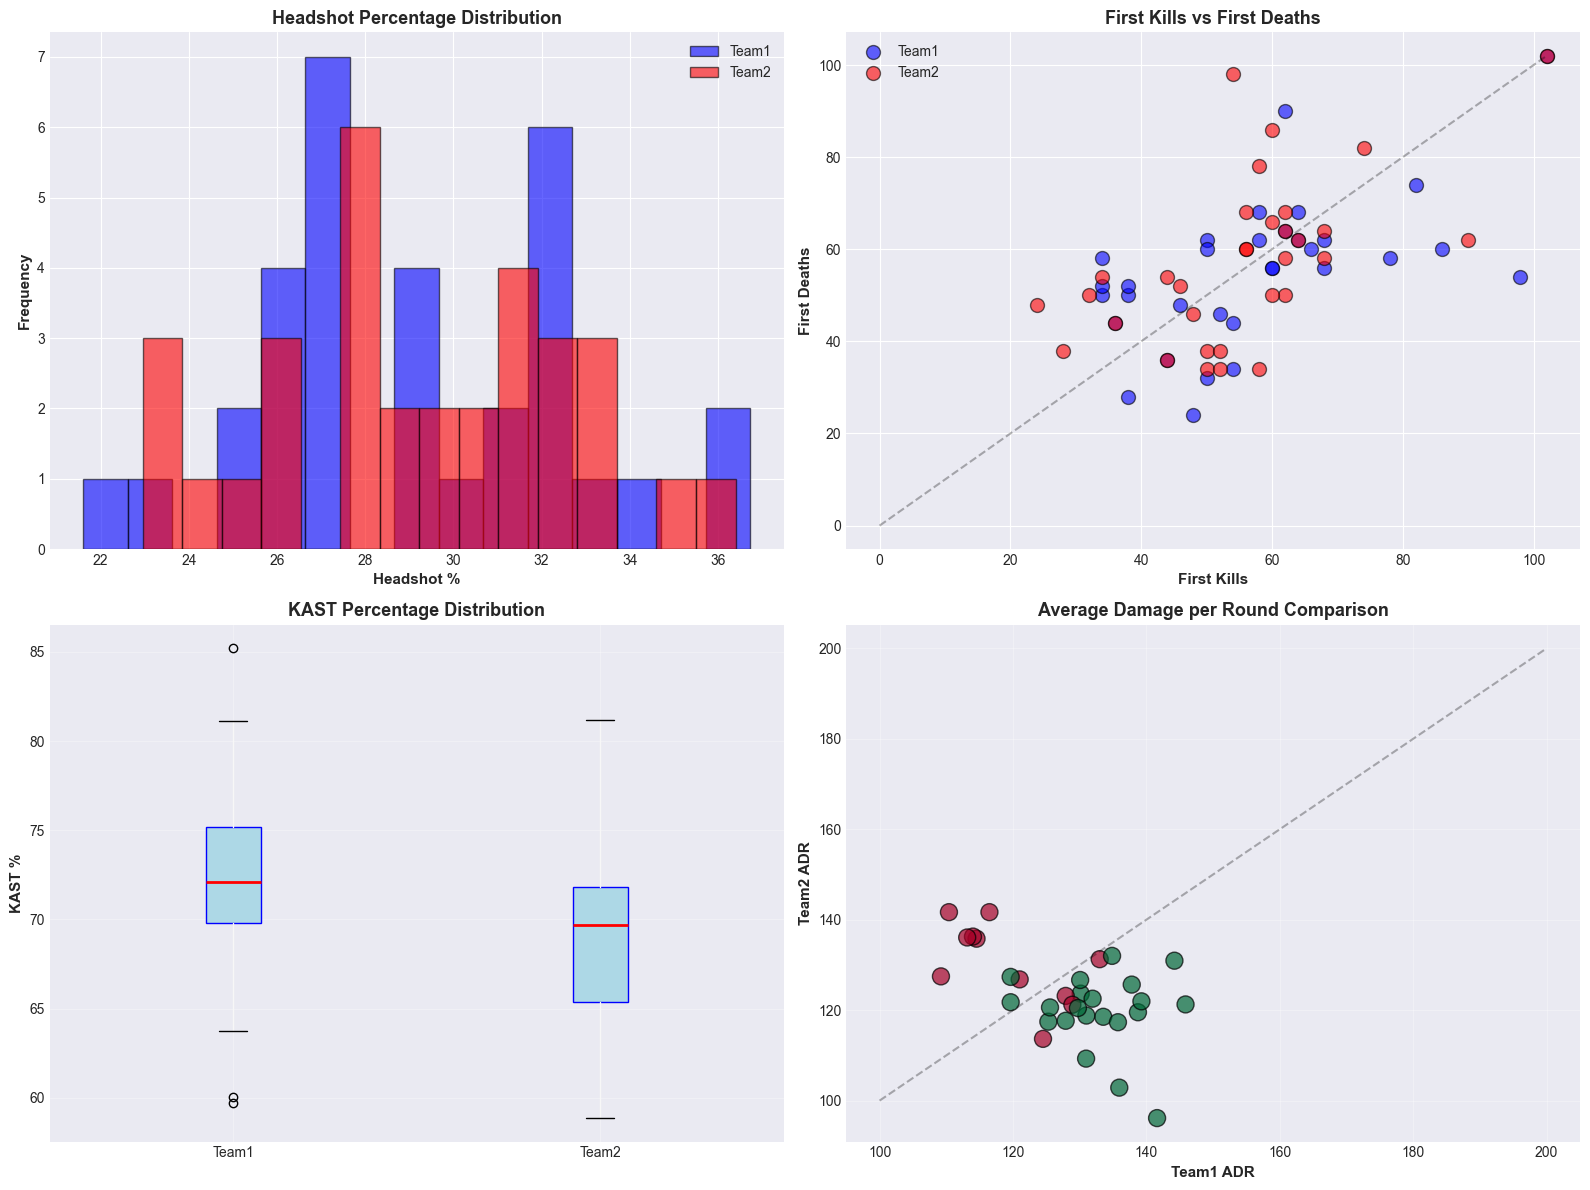

✓ Saved: 10_advanced_metrics.png


In [26]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax = axes[0, 0]
ax.hist(df_ml['team1_avg_hs'], bins=15, alpha=0.6, label='Team1', color='blue', edgecolor='black')
ax.hist(df_ml['team2_avg_hs'], bins=15, alpha=0.6, label='Team2', color='red', edgecolor='black')
ax.set_xlabel('Headshot %', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Headshot Percentage Distribution', fontsize=13, fontweight='bold')
ax.legend()

ax = axes[0, 1]
ax.scatter(df_ml['team1_fk'], df_ml['team1_fd'], alpha=0.6, s=100, 
           c='blue', label='Team1', edgecolors='black')
ax.scatter(df_ml['team2_fk'], df_ml['team2_fd'], alpha=0.6, s=100,
           c='red', label='Team2', edgecolors='black')
ax.plot([0, max(df_ml['team1_fk'].max(), df_ml['team2_fk'].max())],
        [0, max(df_ml['team1_fd'].max(), df_ml['team2_fd'].max())],
        'k--', alpha=0.3)
ax.set_xlabel('First Kills', fontsize=11, fontweight='bold')
ax.set_ylabel('First Deaths', fontsize=11, fontweight='bold')
ax.set_title('First Kills vs First Deaths', fontsize=13, fontweight='bold')
ax.legend()

ax = axes[1, 0]
kast_comparison = pd.DataFrame({
    'Team1': df_ml['team1_avg_kast'],
    'Team2': df_ml['team2_avg_kast']
})
kast_comparison.boxplot(ax=ax, patch_artist=True,
                        boxprops=dict(facecolor='lightblue', color='blue'),
                        medianprops=dict(color='red', linewidth=2))
ax.set_ylabel('KAST %', fontsize=11, fontweight='bold')
ax.set_title('KAST Percentage Distribution', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)

ax = axes[1, 1]
ax.scatter(df_ml['team1_avg_adr'], df_ml['team2_avg_adr'],
           c=df_ml['team1_wins'], cmap='RdYlGn', s=150, alpha=0.7, edgecolors='black')
ax.set_xlabel('Team1 ADR', fontsize=11, fontweight='bold')
ax.set_ylabel('Team2 ADR', fontsize=11, fontweight='bold')
ax.set_title('Average Damage per Round Comparison', fontsize=13, fontweight='bold')
ax.plot([100, 200], [100, 200], 'k--', alpha=0.3)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/10_advanced_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved: 10_advanced_metrics.png")

In [27]:
print("\n Generating evaluation report...")

report_content = f"""
{'='*80}
VALORANT MATCH PREDICTION - MODEL EVALUATION REPORT
{'='*80}

DATASET INFORMATION:
- Total Matches: {len(df_merged)}
- Training Samples: {len(X_train)}
- Test Samples: {len(X_test)}
- Features: {len(feature_columns)}
- Target: Team1 Win Prediction

{'='*80}
MODEL PERFORMANCE SUMMARY:
{'='*80}

"""

for name, result in sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True):
    report_content += f"""
{name}:
  Accuracy:  {result['accuracy']:.4f}
  Precision: {result['precision']:.4f}
  Recall:    {result['recall']:.4f}
  F1-Score:  {result['f1']:.4f}
"""

best_model = max(results, key=lambda x: results[x]['accuracy'])
report_content += f"""
{'='*80}
BEST MODEL: {best_model}
Accuracy: {results[best_model]['accuracy']:.4f}
{'='*80}

TOP 10 MOST IMPORTANT FEATURES:
"""

for idx, row in feature_importance.head(10).iterrows():
    report_content += f"\n{idx+1}. {row['feature']}: {row['importance']:.4f}"

report_content += f"""

{'='*80}
CLASSIFICATION REPORT (Best Model):
{'='*80}
{classification_report(y_test, results[best_model]['predictions'], 
                      target_names=['Team2 Wins', 'Team1 Wins'])}

{'='*80}
FILES GENERATED:
{'='*80}
1. merged_valorant_data.csv - Complete merged dataset
2. model_performance.csv - Model comparison metrics
3. Visualization folder - 10 comprehensive visualization files

VISUALIZATIONS:
- 01_model_comparison.png
- 02_confusion_matrices.png
- 03_roc_curves.png
- 04_feature_importance.png
- 05_learning_curves.png
- 06_data_distribution.png
- 07_player_performance.png
- 08_correlation_heatmap.png
- 09_match_analysis.png
- 10_advanced_metrics.png

{'='*80}
END OF REPORT
{'='*80}
"""

# Save report
with open('MODEL_EVALUATION_REPORT.txt', 'w') as f:
    f.write(report_content)

print("✓ Saved: MODEL_EVALUATION_REPORT.txt")


 Generating evaluation report...
✓ Saved: MODEL_EVALUATION_REPORT.txt


In [28]:
print("Saving predictiions and models...")
predictions_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': results[best_model]['predictions'],
    'Probability_Team1_Win': results[best_model]['probabilities'] if results[best_model]['probabilities'] is not None else None,
    'Correct': (y_test.values == results[best_model]['predictions']).astype(int)
})
predictions_df.to_csv('predictions.csv', index=False)
print("Saved: predictions.csv")
feature_importance.to_csv('feature_importance.csv', index=False)
print("✓ Saved: feature_importance.csv")
import pickle
with open(f'best_model_{best_model.replace(" ", "_").lower()}.pkl', 'wb') as f:
    pickle.dump(results[best_model]['model'], f)
print(f"✓ Saved: best_model_{best_model.replace(' ', '_').lower()}.pkl")

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Saved: scaler.pkl")

print(f"\nBest Model: {best_model}")
print(f"Accuracy: {results[best_model]['accuracy']:.4f}")
print(f"F1-Score: {results[best_model]['f1']:.4f}")

Saving predictiions and models...
Saved: predictions.csv
✓ Saved: feature_importance.csv
✓ Saved: best_model_random_forest.pkl
✓ Saved: scaler.pkl

Best Model: Random Forest
Accuracy: 1.0000
F1-Score: 1.0000
